In [1]:
### Plotting bettis

script_start_time = time()
println("\nimporting packages...")

using Pkg
using Statistics
using LinearAlgebra
using Eirene
using StatsBase
using JLD
using Plots
Pkg.add("ColorSchemes")
using ColorSchemes
using JSON

include("helper_functions.jl")
println("packages and functions imported")
printstyled("Elapsed time = $(time() - script_start_time) seconds \n \n", color = :yellow)

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-9874907867312943972\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-15646287149367718771\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-9874907867312943972\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")


importing packages...
  Updating registry at `/opt/julia/registries/General`
 Resolving package versions...


┌ Warning: Some registries failed to update:
│     — `/opt/julia/registries/General` — registry dirty
└ @ Pkg.Types /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.2/Pkg/src/Types.jl:1171


  Updating `/opt/julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `/opt/julia/environments/v1.2/Manifest.toml`
 [no changes]
packages and functions imported
Elapsed time = 29.638715982437134 seconds 
 


In [71]:
### Set parameters

# Read from config file
config_file = "config091720.json"
config = read_config("$(homedir())/configs/$(config_file)")

# Parameters for all graphs
const NNODES = config["NNODES"]
const MAXDIM = config["MAXDIM"]
const NREPS = config["NREPS"]
const DATE_STRING = config["DATE_STRING"]


### Locate data and find nametags
read_dir = "../processed_data/results/$(NNODES)nodes"
betti_files = filter(x->occursin("_bettis.jld",x), readdir(read_dir))
betti_files = filter(x->occursin(DATE_STRING, x), betti_files)
println("Located the following graph files:")
for betti_file in betti_files
    println(betti_file)
end


# Locate the nametags
nametags = []
for betti_file in betti_files
    println(betti_file)
    tag = split(split(betti_file, "$(DATE_STRING)_")[2], "_bettis")[1]
    nametags = [nametags; tag]
end

nametags = unique(nametags)


Located the following graph files:
IID_70nodes_100reps_091720_forward_bettis.jld
IID_70nodes_100reps_091720_thresh02_edge483_noiseOnly_bettis.jld
IID_70nodes_100reps_091720_thresh02_edge483_threshold_bettis.jld
IID_70nodes_100reps_091720_thresh03_edge725_noiseOnly_bettis.jld
IID_70nodes_100reps_091720_thresh03_edge725_threshold_bettis.jld
IID_70nodes_100reps_091720_thresh04_edge966_noiseOnly_bettis.jld
IID_70nodes_100reps_091720_thresh04_edge966_threshold_bettis.jld
IID_70nodes_100reps_091720_thresh05_edge1208_noiseOnly_bettis.jld
IID_70nodes_100reps_091720_thresh05_edge1208_threshold_bettis.jld
IID_70nodes_100reps_091720_thresh06_edge1449_noiseOnly_bettis.jld
IID_70nodes_100reps_091720_thresh06_edge1449_threshold_bettis.jld
IID_70nodes_100reps_091720_thresh07_edge1691_noiseOnly_bettis.jld
IID_70nodes_100reps_091720_thresh07_edge1691_threshold_bettis.jld
IID_70nodes_100reps_091720_thresh08_edge1932_noiseOnly_bettis.jld
IID_70nodes_100reps_091720_thresh08_edge1932_threshold_bettis.jld
a

geometricConf_70nodes_100reps_001_100_091720_thresh02_edge483_threshold_bettis.jld
geometricConf_70nodes_100reps_001_100_091720_thresh03_edge725_noiseOnly_bettis.jld
geometricConf_70nodes_100reps_001_100_091720_thresh03_edge725_threshold_bettis.jld
geometricConf_70nodes_100reps_001_100_091720_thresh04_edge966_noiseOnly_bettis.jld
geometricConf_70nodes_100reps_001_100_091720_thresh04_edge966_threshold_bettis.jld
geometricConf_70nodes_100reps_001_100_091720_thresh05_edge1208_noiseOnly_bettis.jld
geometricConf_70nodes_100reps_001_100_091720_thresh05_edge1208_threshold_bettis.jld
geometricConf_70nodes_100reps_001_100_091720_thresh06_edge1449_noiseOnly_bettis.jld
geometricConf_70nodes_100reps_001_100_091720_thresh06_edge1449_threshold_bettis.jld
geometricConf_70nodes_100reps_001_100_091720_thresh07_edge1691_noiseOnly_bettis.jld
geometricConf_70nodes_100reps_001_100_091720_thresh07_edge1691_threshold_bettis.jld
geometricConf_70nodes_100reps_001_100_091720_thresh08_edge1932_noiseOnly_bettis.j

probTriangle7_70nodes_100reps_07_091720_thresh07_edge1691_noiseOnly_bettis.jld
probTriangle7_70nodes_100reps_07_091720_thresh07_edge1691_threshold_bettis.jld
probTriangle7_70nodes_100reps_07_091720_thresh08_edge1932_noiseOnly_bettis.jld
probTriangle7_70nodes_100reps_07_091720_thresh08_edge1932_threshold_bettis.jld
probTriangle8_70nodes_100reps_08_091720_conelevel1_bettis.jld
probTriangle8_70nodes_100reps_08_091720_conelevel2_bettis.jld
probTriangle8_70nodes_100reps_08_091720_forward_bettis.jld
probTriangle8_70nodes_100reps_08_091720_thresh02_edge483_noiseOnly_bettis.jld
probTriangle8_70nodes_100reps_08_091720_thresh02_edge483_threshold_bettis.jld
probTriangle8_70nodes_100reps_08_091720_thresh03_edge725_noiseOnly_bettis.jld
probTriangle8_70nodes_100reps_08_091720_thresh03_edge725_threshold_bettis.jld
probTriangle8_70nodes_100reps_08_091720_thresh04_edge966_noiseOnly_bettis.jld
probTriangle8_70nodes_100reps_08_091720_thresh04_edge966_threshold_bettis.jld
probTriangle8_70nodes_100reps_08_

probTriangle98_70nodes_100reps_098_091720_thresh07_edge1691_noiseOnly_bettis.jld
probTriangle98_70nodes_100reps_098_091720_thresh07_edge1691_threshold_bettis.jld
probTriangle98_70nodes_100reps_098_091720_thresh08_edge1932_noiseOnly_bettis.jld
probTriangle98_70nodes_100reps_098_091720_thresh08_edge1932_threshold_bettis.jld
probTriangle99_70nodes_100reps_099_091720_thresh02_edge483_noiseOnly_bettis.jld
probTriangle99_70nodes_100reps_099_091720_thresh02_edge483_threshold_bettis.jld
probTriangle99_70nodes_100reps_099_091720_thresh03_edge725_noiseOnly_bettis.jld
probTriangle99_70nodes_100reps_099_091720_thresh03_edge725_threshold_bettis.jld
probTriangle99_70nodes_100reps_099_091720_thresh04_edge966_noiseOnly_bettis.jld
probTriangle99_70nodes_100reps_099_091720_thresh04_edge966_threshold_bettis.jld
probTriangle99_70nodes_100reps_099_091720_thresh05_edge1208_noiseOnly_bettis.jld
probTriangle99_70nodes_100reps_099_091720_thresh05_edge1208_threshold_bettis.jld
probTriangle99_70nodes_100reps_099

IID_70nodes_100reps_091720_thresh05_edge1208_threshold_bettis.jld
IID_70nodes_100reps_091720_thresh06_edge1449_noiseOnly_bettis.jld
IID_70nodes_100reps_091720_thresh06_edge1449_threshold_bettis.jld
IID_70nodes_100reps_091720_thresh07_edge1691_noiseOnly_bettis.jld
IID_70nodes_100reps_091720_thresh07_edge1691_threshold_bettis.jld
IID_70nodes_100reps_091720_thresh08_edge1932_noiseOnly_bettis.jld
IID_70nodes_100reps_091720_thresh08_edge1932_threshold_bettis.jld
assortative_70nodes_100reps_20_5_10_5_091720_forward_bettis.jld
assortative_70nodes_100reps_20_5_10_5_091720_thresh02_edge483_noiseOnly_bettis.jld
assortative_70nodes_100reps_20_5_10_5_091720_thresh02_edge483_threshold_bettis.jld
assortative_70nodes_100reps_20_5_10_5_091720_thresh03_edge725_noiseOnly_bettis.jld
assortative_70nodes_100reps_20_5_10_5_091720_thresh03_edge725_threshold_bettis.jld
assortative_70nodes_100reps_20_5_10_5_091720_thresh04_edge966_noiseOnly_bettis.jld
assortative_70nodes_100reps_20_5_10_5_091720_thresh04_edge9

geometricConf_70nodes_100reps_001_100_091720_thresh06_edge1449_noiseOnly_bettis.jld
geometricConf_70nodes_100reps_001_100_091720_thresh06_edge1449_threshold_bettis.jld
geometricConf_70nodes_100reps_001_100_091720_thresh07_edge1691_noiseOnly_bettis.jld
geometricConf_70nodes_100reps_001_100_091720_thresh07_edge1691_threshold_bettis.jld
geometricConf_70nodes_100reps_001_100_091720_thresh08_edge1932_noiseOnly_bettis.jld
geometricConf_70nodes_100reps_001_100_091720_thresh08_edge1932_threshold_bettis.jld
probTriangle0_70nodes_100reps_0_091720_forward_bettis.jld
probTriangle0_70nodes_100reps_0_091720_thresh02_edge483_noiseOnly_bettis.jld
probTriangle0_70nodes_100reps_0_091720_thresh02_edge483_threshold_bettis.jld
probTriangle0_70nodes_100reps_0_091720_thresh03_edge725_noiseOnly_bettis.jld
probTriangle0_70nodes_100reps_0_091720_thresh03_edge725_threshold_bettis.jld
probTriangle0_70nodes_100reps_0_091720_thresh04_edge966_noiseOnly_bettis.jld
probTriangle0_70nodes_100reps_0_091720_thresh04_edge9

probTriangle8_70nodes_100reps_08_091720_thresh02_edge483_threshold_bettis.jld
probTriangle8_70nodes_100reps_08_091720_thresh03_edge725_noiseOnly_bettis.jld
probTriangle8_70nodes_100reps_08_091720_thresh03_edge725_threshold_bettis.jld
probTriangle8_70nodes_100reps_08_091720_thresh04_edge966_noiseOnly_bettis.jld
probTriangle8_70nodes_100reps_08_091720_thresh04_edge966_threshold_bettis.jld
probTriangle8_70nodes_100reps_08_091720_thresh05_edge1208_noiseOnly_bettis.jld
probTriangle8_70nodes_100reps_08_091720_thresh05_edge1208_threshold_bettis.jld
probTriangle8_70nodes_100reps_08_091720_thresh06_edge1449_noiseOnly_bettis.jld
probTriangle8_70nodes_100reps_08_091720_thresh06_edge1449_threshold_bettis.jld
probTriangle8_70nodes_100reps_08_091720_thresh07_edge1691_noiseOnly_bettis.jld
probTriangle8_70nodes_100reps_08_091720_thresh07_edge1691_threshold_bettis.jld
probTriangle8_70nodes_100reps_08_091720_thresh08_edge1932_noiseOnly_bettis.jld
probTriangle8_70nodes_100reps_08_091720_thresh08_edge1932

probTriangle99_70nodes_100reps_099_091720_thresh03_edge725_threshold_bettis.jld
probTriangle99_70nodes_100reps_099_091720_thresh04_edge966_noiseOnly_bettis.jld
probTriangle99_70nodes_100reps_099_091720_thresh04_edge966_threshold_bettis.jld
probTriangle99_70nodes_100reps_099_091720_thresh05_edge1208_noiseOnly_bettis.jld
probTriangle99_70nodes_100reps_099_091720_thresh05_edge1208_threshold_bettis.jld
probTriangle99_70nodes_100reps_099_091720_thresh06_edge1449_noiseOnly_bettis.jld
probTriangle99_70nodes_100reps_099_091720_thresh06_edge1449_threshold_bettis.jld
probTriangle99_70nodes_100reps_099_091720_thresh07_edge1691_noiseOnly_bettis.jld
probTriangle99_70nodes_100reps_099_091720_thresh07_edge1691_threshold_bettis.jld
probTriangle99_70nodes_100reps_099_091720_thresh08_edge1932_noiseOnly_bettis.jld
probTriangle99_70nodes_100reps_099_091720_thresh08_edge1932_threshold_bettis.jld
probTriangle9_70nodes_100reps_09_091720_thresh02_edge483_noiseOnly_bettis.jld
probTriangle9_70nodes_100reps_09_0

25-element Array{Any,1}:
 "forward"                    
 "thresh02_edge483_noiseOnly" 
 "thresh02_edge483_threshold" 
 "thresh03_edge725_noiseOnly" 
 "thresh03_edge725_threshold" 
 "thresh04_edge966_noiseOnly" 
 "thresh04_edge966_threshold" 
 "thresh05_edge1208_noiseOnly"
 "thresh05_edge1208_threshold"
 "thresh06_edge1449_noiseOnly"
 "thresh06_edge1449_threshold"
 "thresh07_edge1691_noiseOnly"
 "thresh07_edge1691_threshold"
 "thresh08_edge1932_noiseOnly"
 "thresh08_edge1932_threshold"
 "conelevel10"                
 "conelevel1"                 
 "conelevel2"                 
 "conelevel3"                 
 "conelevel4"                 
 "conelevel5"                 
 "conelevel6"                 
 "conelevel7"                 
 "conelevel8"                 
 "conelevel9"                 

In [ ]:


for (j,nametag) in enumerate(nametags)
    
    ## Create one large plot with all of the betti curves
    betti_files_nametag = filter(x -> occursin("$(nametag)",x), betti_files)
    model_names = [split(betti_file_nametag,"_")[1] for betti_file_nametag in betti_files_nametag]
    
    nModels = length(betti_files_nametag)
    nEdges = binomial(NNODES, 2)
    bettisAll = zeros(NREPS, nEdges, MAXDIM, nModels)
    
    for (i,betti_file_nametag) in enumerate(betti_files_nametag)

        # Read in Betti curves
        betti_dict = load("$(read_dir)/$(betti_file_nametag)")
        bettisAll[:,:,:, i] = betti_dict["bettisArray"]
        println(betti_file_nametag)

    end

    bettisAllAvg = dropdims(mean(bettisAll, dims=1), dims=1)
    println("Size bettisAllAvg is $(size(bettisAllAvg))")

    # Finally plot
    p1a = plot(bettisAllAvg[:,1,:], layout = 32, size = (2000,1600), title = ["$(model_names[i])" for j=1:1, i=1:nModels])
    for d=2:MAXDIM
        plot!(bettisAllAvg[:,d,:],legend = nothing, xlabel = "Edges added", ylabel="Beta_k")

    end
    
    # If the file is of threshold type, add the threshold line
    if occursin("threshold", nametag)
        
        # Get threshold edge
        thresh_string = split(split(nametag,"edge")[2],"_")[1]
        threshold_edge = parse(Int, thresh_string)
        println("processing threshold edge $(threshold_edge)")
        
        # Plot the vertical line
        vline!(transpose([threshold_edge for i=1:nModels]), color=:gray)
#         yaxis!([zeros(1,length(yaxis_lims)), yaxis_lims])
    end


    savefig("../figures/all_bettis_$(nametag)_$(DATE_STRING).pdf")
end






In [ ]:
##### Make special figures for thresholded stuff

# Maybe just betti bar first

# Filter to just the thresholds
thresh_files = filter(x->occursin("thresh",x), betti_files)
thresh_files = filter(x->!occursin("noiseOnly",x), thresh_files)

# Locate the thresh nametages
thresh_nametags = []
for thresh_file in thresh_files
    tag = split(split(thresh_file, "$(DATE_STRING)_")[2], "_bettis")[1]
    thresh_nametags = [thresh_nametags; tag]
end

thresh_nametags = unique(thresh_nametags)

## And locate the model names
model_names = []
for thresh_file in thresh_files
    name = split(thresh_file, "_thresh")[1]
    model_names = [model_names; name]
end

model_names = unique(model_names)


In [ ]:
nEdges = binomial(NNODES, 2)
plot_array3 = Any[]
plot_array4 = Any[]
for (j,model_name) in enumerate(model_names)
# model_name = "assortative_70nodes_50reps_15_5_10_5_091520"
    bettis = []

    model = split(model_name, "_")[1]
    # Loop through threshold vals and create vector of means and begin plotting

    betti_peaks_all = zeros(NREPS, MAXDIM, length(thresh_nametags))

    p3 = plot(layout = (MAXDIM, 1))

    rho_vec = []
    max_val_k =[]
    mean_bettis = []
    max_locs = Array{Float64}(undef, (0,MAXDIM))
    max_vals = Array{Float64}(undef, (0,MAXDIM))

    
    for (i,thresh_nametag) in enumerate(thresh_nametags)
        
        # Load data
        bettis_dict = load("$(read_dir)/$(model_name)_$(thresh_nametag)_bettis.jld")
        bettis = bettis_dict["bettisArray"]
        
    
        rho = split(split(thresh_nametag, "thresh")[2], "_")[1]
        rho = replace(rho, "0" => "0.")
        rho = parse(Float64, rho)
        
        rho_vec = [rho_vec; rho]
        
        mean_bettis = dropdims(mean(bettis, dims=1), dims=1)
    
        # Find max and location of max peak
        max_val_k = dropdims(maximum(mean_bettis, dims=1), dims=1)
        max_vals = [max_vals; transpose(max_val_k)]
    
        # Find locations of max value
        max_loc = zeros(1,4)
        for dim in collect(1:MAXDIM)
            max_loc[1, dim] = findfirst(mean_bettis[:, dim].==max_val_k[dim])
        end
        max_locs = [max_locs; max_loc]
            
        

    
        plot!([1:nEdges],mean_bettis, c=[[:blue] [:green] [:red] [:pink]], alpha = (rho+0.1), legend =false, lw=2)
#         xlabel!("Edges")
        ylabel!("Betti_k")

        
        
        
    end
    
    
    p4 = plot(size=(500,300))
    plot!(max_locs, max_vals, alpha = rho_vec, c=[[:blue] [:green] [:red] [:pink]],
        legend = false, m=:dot, lw=3, xlims=[0,nEdges])
    xlabel!("Peak Location")
    ylabel!("Peak Value")
    title!("$(model)")


        
#     plot(p3,p4,layout=(2, 1), size=(500,1000))
    push!(plot_array4,p4)
    push!(plot_array3,p3)


    
    
    
end

plot(plot_array4..., size = (3000,2000))
savefig("../figures/all_peakplots_$(DATE_STRING).pdf")


plot(plot_array3..., size = (1500,3000))
savefig("../figures/all_bettisthreshs_$(DATE_STRING).pdf")

cone check

In [68]:
##### Make special figures for cone check stuff



# Filter to just the thresholds
cone_files = filter(x->occursin("eireneoutput",x), readdir(read_dir))
cone_files = filter(x->occursin("conelevel",x), cone_files)


## And locate the model names
model_names = []
for cone_file in cone_files
    name = split(cone_file, "_conelevel")[1]
    model_names = [model_names; name]
end

model_names = unique(model_names)

# identify cone_levels
cone_nametags


2-element Array{Any,1}:
 "conelevel1"
 "conelevel2"

In [69]:
nEdges = binomial(NNODES, 2)
plot_array = Any[]
# model_name = "coreperiphery_70nodes_100reps_15_5_10_5_091720"
for (j,model_name) in enumerate(model_names)

    # Load in ph_forward
    barcode_forward = load("$(read_dir)/$(model_name)_forward.jld", "barcodeArray")
    
    # Create counts of each 
    barcode_forward_counts = (length.(barcode_forward))./2
    
    
    # Find levels 
    # Locate the thresh nametages
    cone_nametags = []
    for cone_file in filter(x -> (occursin("conelevel",x) && occursin("$(model_name)",x)),cone_files)
        tag = split(split(cone_file, "eireneoutput_")[2], ".jld")[1]
        cone_nametags = [cone_nametags; tag]
    end

    cone_nametags = unique(cone_nametags)
    println(cone_nametags)

    
    

    model = split(model_name, "_")[1]

    mean_counts = zeros(4,length(cone_nametags)+1)
    mean_counts[:,1] = dropdims(mean(barcode_forward_counts, dims=1), dims=1)

    level_vec = [0]
    barcodei = []
    
    for (i,cone_nametag) in enumerate(sort(cone_nametags))
        
        # Load data
        barcodei = load("$(read_dir)/$(model_name)_$(cone_nametag).jld", "barcodeArray")
        
    
        level = split(cone_nametag, "level")[2]
        level = parse(Float64, level)
        
        level_vec = [level_vec; level]
        
        # Create counts of each 
        barcode_counts = (length.(barcodei))./2
        mean_counts[:,i+1] = dropdims(mean(barcode_counts, dims=1), dims=1)
    

        
        
        
    end

    pi = plot(sort(level_vec), transpose(mean_counts[:, sortperm(level_vec)]), m=:dot, lw=1)
    xlabel!("nodes removed")
    ylabel!("Barcode counts")
    title!("$(model)")
    
    push!(plot_array,pi)



    
    
    
end

plot(plot_array..., size = (3000,2000))
savefig("../figures/all_conecounts_$(DATE_STRING).pdf") 


# plot(plot_array3..., size = (1500,3000))
# savefig("../figures/all_bettisthreshs_$(DATE_STRING).pdf")

Any["conelevel1"]
Any["conelevel1", "conelevel2"]
Any["conelevel1", "conelevel10", "conelevel2", "conelevel3", "conelevel4", "conelevel5", "conelevel6", "conelevel7", "conelevel8", "conelevel9"]
Any["conelevel1", "conelevel10", "conelevel2", "conelevel3", "conelevel4", "conelevel5", "conelevel6", "conelevel7", "conelevel8", "conelevel9"]
Any["conelevel1"]
Any["conelevel1", "conelevel2", "conelevel3", "conelevel4", "conelevel5", "conelevel6", "conelevel7", "conelevel8", "conelevel9"]
Any["conelevel1", "conelevel10", "conelevel2", "conelevel3", "conelevel4", "conelevel5", "conelevel6", "conelevel7", "conelevel8", "conelevel9"]
Any["conelevel1", "conelevel2", "conelevel3", "conelevel4", "conelevel5"]
Any["conelevel1"]
Any["conelevel1"]
Any["conelevel1", "conelevel2"]
Any["conelevel1", "conelevel2"]
Any["conelevel1", "conelevel2"]
Any["conelevel1", "conelevel2", "conelevel3"]
Any["conelevel1", "conelevel2", "conelevel3"]
Any["conelevel1", "conelevel2", "conelevel3", "conelevel4", "coneleve

In [55]:
level_vec

11-element Array{Float64,1}:
  0.0
  1.0
 10.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0

In [86]:
## triangle graph model
nNodes = 30
p=0.5
open_triangles = []
adj_2 = []

    nEdges = binomial(nNodes,2)
    adj = zeros(nNodes,nNodes)

    edges_left = copy(nEdges)

    while edges_left > 0
                    
        # Flip a coin
        r = rand(1)[1]

        if r < p  # See if there's a triangle and if there is, add it. If not, add edge randomly

            # Are any triangles possible?
            adj_2 = adj^2
            adj_2[diagind(adj_2)] .= 0
            
            possible_ot = Tuple.(findall(adj_2 .> 0))
            current_edges = Tuple.(findall(adj .> 0))

            # Remove n,n open triangles
            possible_ot = filter(x -> (x[1] != x[2]), possible_ot)

            # Check for non-closed open triangles
            open_triangles = []
            for pots in possible_ot
                if !(pots in current_edges)
                    open_triangles = [open_triangles; pots]
                end
            end

            if length(open_triangles) > 0

                # Then we can add an edge that completes a triangle, weighted by time of appearance.
                ot_weights = [adj_2[ot[1], ot[2]] for ot in open_triangles]
                new_edge = sample(open_triangles, Weights(ot_weights))
            else

                # Then we add a new edge randomly.
                # println("no open triangles")
                open_edges = Tuple.(findall(adj .== 0))
                open_edges = filter(x -> (x[1] != x[2]), open_edges)
                new_edge = sample(open_edges)
            end

            
        else  # add an edge randomly
            
            open_edges = Tuple.(findall(adj .== 0))
            open_edges = filter(x -> (x[1] != x[2]), open_edges)
            new_edge = sample(open_edges)
            

        end

        
        adj[new_edge[1], new_edge[2]] = edges_left
        adj[new_edge[2], new_edge[1]] = edges_left
            
        

            edges_left = edges_left-1
        
    end


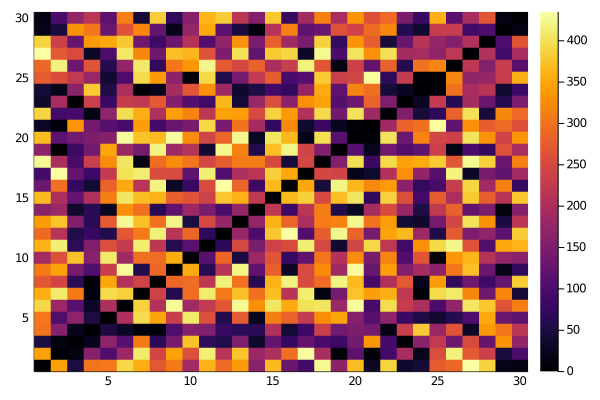

In [87]:
heatmap(adj)

In [91]:
ProbabilityWeights([adj_2[ot[1], ot[2]] for ot in open_triangles])

2-element ProbabilityWeights{Float64,Float64,Array{Float64,1}}:
 1.102602e6
 1.102602e6

In [90]:
[adj_2[ot[1], ot[2]] for ot in open_triangles]

2-element Array{Float64,1}:
 1.102602e6
 1.102602e6

In [92]:
open_triangles

2-element Array{Any,1}:
 (24, 7)
 (7, 24)